In [118]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae
from fbprophet.plot import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/mauna_loa.csv')
df.head()

,year,month,day,decimal,ppm,#days,1 yr ago,10 yr ago,since 1800
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07


In [25]:
df['date'] = pd.to_datetime(df[['year','month','day']])

In [26]:
df['date'].head()

0   1974-05-19
1   1974-05-26
2   1974-06-02
3   1974-06-09
4   1974-06-16
Name: date, dtype: datetime64[ns]

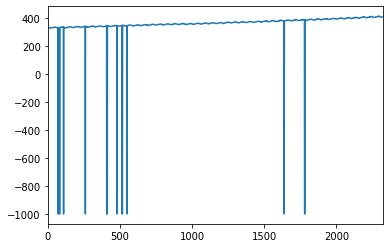

In [27]:
df['ppm'].plot()

In [28]:
df['ppm_fixed']= df['ppm'].map(lambda x: np.nan if x <0 else x)
df['ppm_fixed'].fillna(method='backfill', inplace=True)

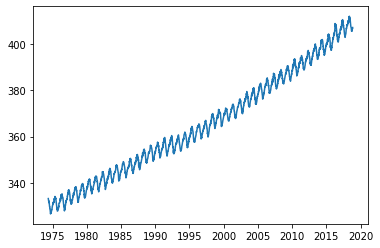

In [29]:
plt.plot(df.date, df.ppm_fixed);

In [49]:
cut_year = 2008
train = df[df.year < cut_year]
test = df[df.year >= cut_year]

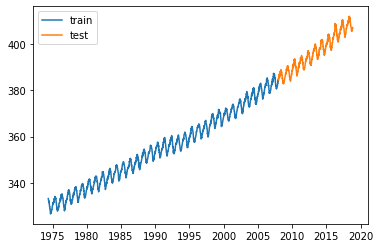

In [50]:
plt.plot(train.date, train.ppm_fixed, label='train');
plt.plot(test.date, test.ppm_fixed, label='test');
plt.legend();

Prophet

In [51]:
fb_df = train[['date', 'ppm_fixed']].copy()
fb_df.columns= ['ds', 'y']
fb_df.head()

,ds,y
0,1974-05-19,333.34
1,1974-05-26,332.95
2,1974-06-02,332.32
3,1974-06-09,332.18
4,1974-06-16,332.37


In [130]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(fb_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
f:\Users\User\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [131]:
len(test)

566

In [132]:
future = m.make_future_dataframe(periods = len(test), freq='W', include_history=False)
future.head()

,ds
0,2008-01-06
1,2008-01-13
2,2008-01-20
3,2008-01-27
4,2008-02-03


In [133]:
forecast  = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-06,387.462136,384.455656,385.450652,387.462136,387.462136,-2.537695,-2.537695,-2.537695,-2.418608,-2.418608,-2.418608,-0.119087,-0.119087,-0.119087,0.0,0.0,0.0,384.924441
1,2008-01-13,387.502582,384.609508,385.641833,387.502582,387.502582,-2.363455,-2.363455,-2.363455,-2.418608,-2.418608,-2.418608,0.055153,0.055153,0.055153,0.0,0.0,0.0,385.139127
2,2008-01-20,387.543028,384.825082,385.883445,387.543028,387.543028,-2.194076,-2.194076,-2.194076,-2.418608,-2.418608,-2.418608,0.224532,0.224532,0.224532,0.0,0.0,0.0,385.348952
3,2008-01-27,387.583474,385.067526,386.069283,387.583474,387.583474,-2.033885,-2.033885,-2.033885,-2.418608,-2.418608,-2.418608,0.384723,0.384723,0.384723,0.0,0.0,0.0,385.549589
4,2008-02-03,387.623920,385.244322,386.238870,387.623920,387.623920,-1.886645,-1.886645,-1.886645,-2.418608,-2.418608,-2.418608,0.531963,0.531963,0.531963,0.0,0.0,0.0,385.737275


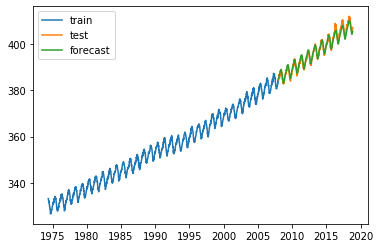

In [134]:
plt.plot(train.date, train.ppm_fixed, label='train');
plt.plot(test.date, test.ppm_fixed, label='test');
plt.plot(test.date, forecast.yhat, label='forecast');
plt.legend();

In [135]:
def linear_function(manua, k=None, b=0):
    mean_value = np.mean(manua)
    if k is None:
        return [mean_value] * len(manua)
    return [idx*k +b for idx, _ in enumerate(manua)]

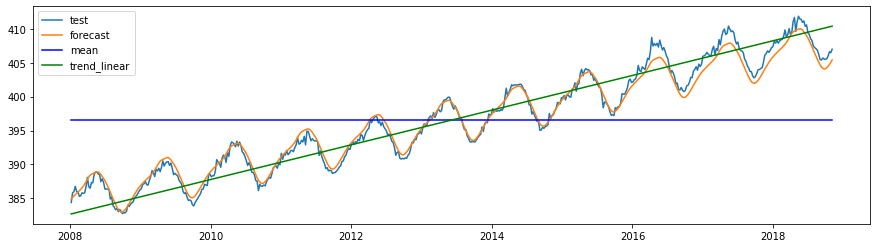

In [136]:
plt.figure(figsize=(15,4))
plt.plot(test.date, test.ppm_fixed, label='test');
plt.plot(test.date, forecast.yhat, label='forecast');
plt.plot(test.date, linear_function(test.ppm_fixed), label='mean', c='blue')
plt.plot(test.date, linear_function(test.ppm_fixed, k=0.049, b=382.7), label='trend_linear', c='green')
plt.legend();

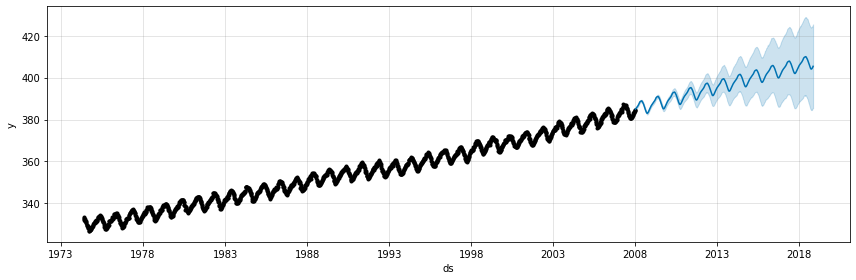

In [137]:
plot(m, forecast, figsize=(12, 4));

In [138]:
print('mae-mean:', mae(test.ppm_fixed, linear_function(test.ppm_fixed)))
print('mae-trend_linear:', mae(test.ppm_fixed, linear_function(test.ppm_fixed,k=0.049, b=382.7)))

mae-mean: 6.5032341520059
mae-trend_linear: 2.0784469964664325
